In [1]:
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import tables
from tqdm import tqdm
import os
from random import shuffle
from IPython.display import clear_output
from sklearn import metrics
import time
%matplotlib inline

import os
USE_GPU = True
os.environ['CUDA_VISIBLE_DEVICES'] = '1' if USE_GPU else ''
EPS = 1e-15

In [2]:
# for phase 1 set num_classes=3
# for phase 2 set num_classes=4
num_classes = 4

energy_cut = 0.01
zero_class_exists = False

num_nn_output = num_classes - (not zero_class_exists)

In [3]:
train_file = '/mnt/vbelavin/train_3-4.csv'
test_file = '/mnt/vbelavin/test_3-4.csv'
submission_file = 'submission_simplified_3-4.csv'

In [4]:
%load_ext autoreload
%autoreload 2

# Prepare data

In [5]:
import sys

from tools.base import plot_3d, hdf5_to_numpy, plot_3d_with_edges, csv_to_numpy, X_MAX, Y_MAX, Z_MAX
from tools.tools import stretch_array

In [6]:
import os
import psutil

process = psutil.Process(os.getpid())

In [7]:
process.memory_info().rss / 2**30

0.13283157348632812

In [8]:
%%time
X, Y, M, _ = csv_to_numpy(file=train_file, num_classes=num_classes, 
                               zero_class_exists=zero_class_exists, energy_cut=energy_cut)

100%|██████████| 9999/9999 [00:26<00:00, 380.04it/s]


CPU times: user 43.7 s, sys: 6.81 s, total: 50.6 s
Wall time: 41.1 s


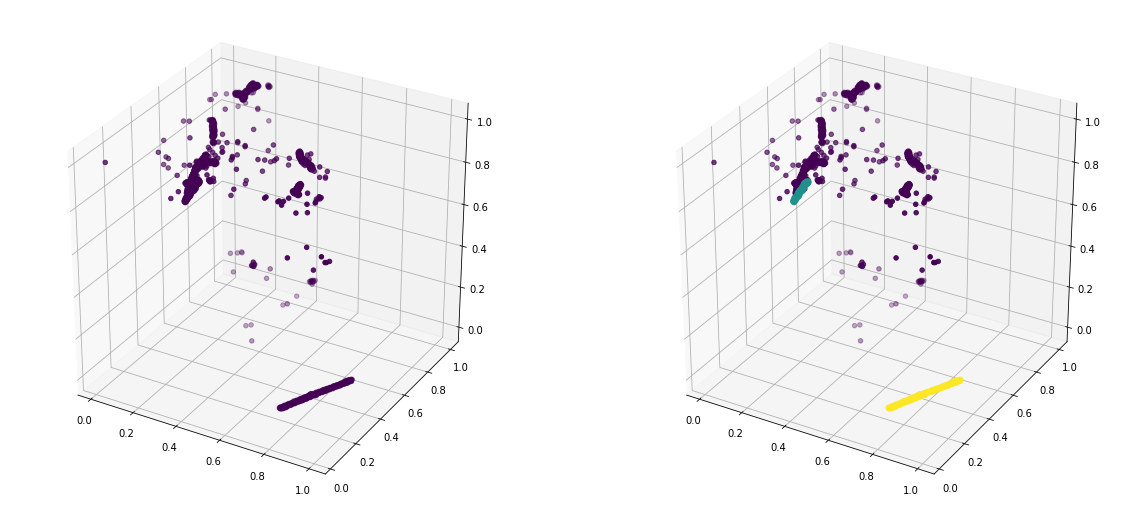

In [9]:
k = -1
plot_3d(X[k], Y[k])

## Creation of graph dataset


![title](img/knn_graph.png)

To compute graph on which we are going to do inference we will use K-nearest neighbours graph. This algorithm draws edges from node(which is, in our case, a hit in the detector) to K closest points.

Tunable parameter:

__n_neighbors__ -- number of neighbours for k-nearest neighbours graph algo(http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.kneighbors_graph.html).

### Ideas

  * try to play with default params;
  * explore different ideas for graph computation: heuristics, radius neighbors graph, etc.;
  * different metrics: manhattan, l1, cosine, metric learning(__hot!__), etc.;

In [10]:
n_neighbors = 20

in_degree_max, out_degree_max = 0, 0

In [14]:
from tools.simplified_clustering import generate_graph_dataset

In [13]:
X_clusters_graph = []
for k in tqdm(range(len(X))):
    if len(X[k]) == 0:
        continue
    # construction of graph based on aggregated statistics
    X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X[k], Y=Y[k], M=M[k],
                                                                                        n_neighbors=n_neighbors)
    in_degree_max = max(in_degree_max_local, in_degree_max)
    out_degree_max = max(out_degree_max_local, out_degree_max)
    
    X_clusters_graph.append(X_cluster_graph)

100%|██████████| 9999/9999 [16:48<00:00,  9.92it/s]


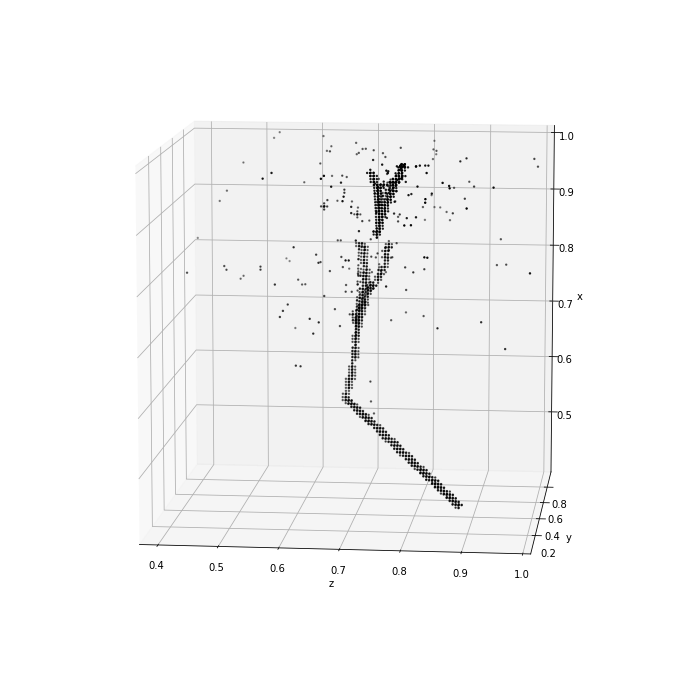

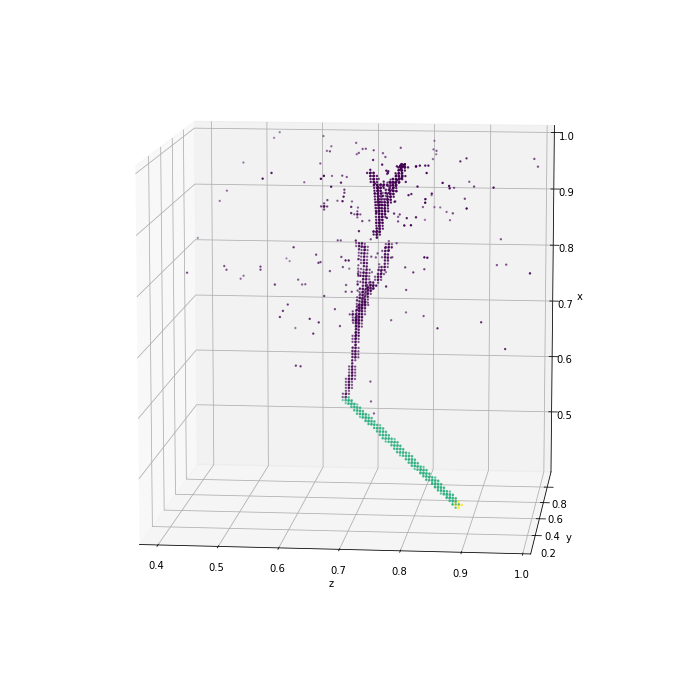

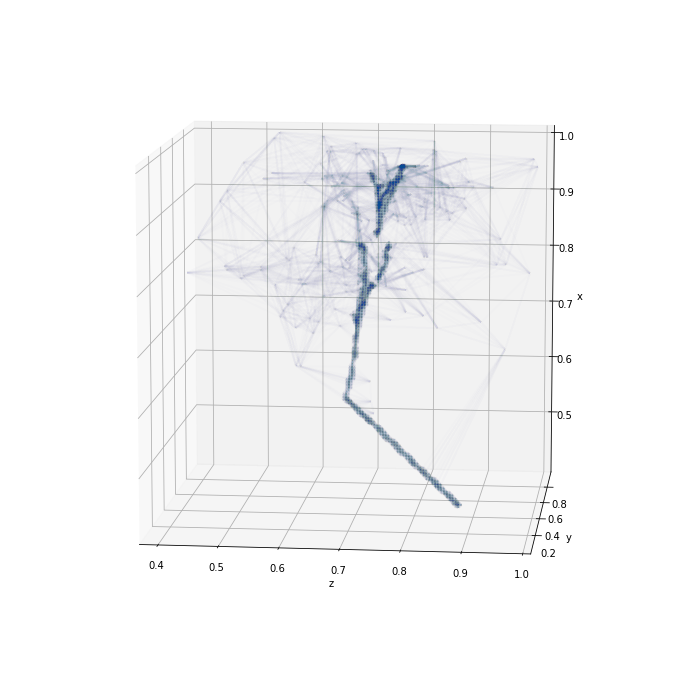

In [15]:
k = 0
plot_3d_with_edges(X[k], Y[k], X_clusters_graph[k]['X_cluster_in_out'])

### What is __in_degree_max__ and __out_degree_max__?

Well, when you are working with tensorflow you have to specify shape of your data(at least number of columns).

```
shape = (number_of_nodes, out_degree/in_degree)
```

__max_out_degree__ is fixed and equal __n_neighbors__ in our setting, but __in_degree_max__ could be different across different events. 

To anticipate it we are padding all events with edges to non-existing node. Latter this should be taken into account in the MPNN-algorithm.

In [16]:
in_degree_max, out_degree_max

(60, 20)

In [17]:
# padding
for X_cluster_graph in X_clusters_graph:
    X_cluster_graph['X_cluster_messages_out'] = stretch_array(X_cluster_graph['X_cluster_messages_out'], 
                                                              n=out_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))
    
    X_cluster_graph['X_cluster_messages_in'] = stretch_array(X_cluster_graph['X_cluster_messages_in'], 
                                                              n=in_degree_max, 
                                                              fill_value=len(X_cluster_graph['X_cluster_edges']))

# Deep learning model (MPNN)




In [18]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda, GRUCell, GRU
from keras.optimizers import RMSprop
from keras import backend as K
import keras
import tensorflow as tf
from keras.layers import Dropout
from keras.models import Sequential
from keras.activations import relu

config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

/mnt/vbelavin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Placeholders

In [19]:
X_cluster_graph['X_cluster_nodes'].shape, X_cluster_graph['X_cluster_edges'].shape

((1555, 1), (31100, 5))

__X_nodes__ -- features per hit(i.e. energy).

__X_edges__ -- features for each edge that connects two hits(i.e. relative difference of coordinates).

__X_labels__ -- labels ;)

In [20]:
ndim_features_nodes = 4
ndim_features_edges = 5
ndim_message = 6

X_nodes = K.placeholder(shape=(None, ndim_features_nodes)) # features of nodes
X_edges = K.placeholder(shape=(None, ndim_features_edges)) # features of edges
X_labels = K.placeholder(shape=(None, num_nn_output)) # labels

__X_nodes_in_out__ -- edge list.

__X_messages_in__ -- in-adjacency lists.

__X_messages_out__ -- out-adjacency lists.

All these graph representations are equivalent. 

In [21]:
X_nodes_in_out = K.placeholder(shape=(None, 2), dtype=np.int32) # edges
X_messages_in = K.placeholder(shape=(None, in_degree_max), dtype=np.int32) # shape = (none, size of neighbourhood)
X_messages_out = K.placeholder(shape=(None, out_degree_max), dtype=np.int32) # shape = (none, size of neighbourhood)

# fake messages to(or from) non-existing node
fake_message_const = K.constant(value=[ndim_message * [-np.inf]]) 

In [22]:
placeholders = {
    'X_nodes': X_nodes,
    'X_edges': X_edges,
    'X_labels': X_labels,
    'X_nodes_in_out': X_nodes_in_out,
    'X_messages_in': X_messages_in,
    'X_messages_out': X_messages_out
}

### NNs

In [23]:
steps = 3

message_passers = {
    0: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu), 
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ]
                 ),
    1: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu), 
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ]
                 ),    
    2: Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_features_nodes + ndim_features_edges,), activation=relu), 
                      Dropout(rate=0.05),
                      Dense(ndim_message, activation=relu),
                      Dropout(rate=0.05),
                  ]
                 )
}

In [24]:
#state_updater = tf.contrib.rnn.GRUCell(num_units=ndim_features_nodes, )
state_updater = Sequential(layers=[
                      Dense(16, input_shape=(2 * ndim_message + ndim_features_nodes,), activation=relu), 
                      Dense(ndim_features_nodes),
                                  ]
                          )

In [25]:
readout = Dense(num_nn_output, input_shape=(ndim_features_nodes,), activation=keras.activations.softmax)

### MPNN construction

A brief explanation of MPNN algorithm in a diagram for a following toy graph:

![](img/example_graph.png)

Algorithm:

![](img/mpnn.png)


And corresponding code with comments:

In [26]:
def build_network(X_nodes, X_edges, X_nodes_in_out, 
                  X_messages_in, X_messages_out, message_passers, 
                  state_updater, readout, ndim_features_nodes, fake_message_const, steps):
    # nodes 'talks' to each other several times which is defined by __step__ parameter
    for step in range(steps):
        # messages from node to node
        messages = message_passers[step](
            K.concatenate(
                [
                    K.reshape(K.gather(reference=X_nodes, indices=X_nodes_in_out), 
                              shape=(-1, 2 * ndim_features_nodes)), 
                    X_edges
                ], axis=1
            )
        )
        # correct dealing with non-existing edge
        messages = K.concatenate([messages, fake_message_const], axis=0)
        messages = tf.where(tf.is_inf(messages), tf.zeros_like(messages), messages)

        # aggregating messages that came into the node
        messages_aggregated_in = K.max(K.gather(reference=messages, indices=X_messages_in), axis=1)
        # ... and those exiting node
        messages_aggregated_out = K.max(K.gather(reference=messages, indices=X_messages_out), axis=1)

        # update nodes states based on messages and previous state
        X_nodes = state_updater(K.concatenate([messages_aggregated_in, messages_aggregated_out, X_nodes], axis=1))

    return readout(X_nodes)

In [27]:
from tools.mpnn import build_network, run_train, run_test

In [28]:
X_predictions = build_network(X_nodes=X_nodes, 
                              X_edges=X_edges, 
                              X_nodes_in_out=X_nodes_in_out, 
                              X_messages_in=X_messages_in, 
                              X_messages_out=X_messages_out, 
                              message_passers=message_passers, 
                              state_updater=state_updater, 
                              readout=readout, 
                              steps=steps, 
                              ndim_features_nodes=ndim_features_nodes,
                              fake_message_const=fake_message_const)

In [29]:
loss_tf = tf.reduce_mean(keras.losses.categorical_crossentropy(X_labels, X_predictions))
accuracy_tf = tf.reduce_mean(keras.metrics.categorical_accuracy(X_labels, X_predictions))

In [30]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss_tf, var_list=tf.trainable_variables())

/mnt/vbelavin/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [31]:
sess = tf.Session()
init = tf.global_variables_initializer()
init.run(session=sess)

## Split dataset

In [32]:
TRAIN_SIZE = int(len(X_clusters_graph) * 0.8)
print(TRAIN_SIZE)
shuffle(X_clusters_graph)

X_clusters_graph_train = X_clusters_graph[:TRAIN_SIZE]
X_clusters_graph_eval = X_clusters_graph[TRAIN_SIZE:]

7999


### Train

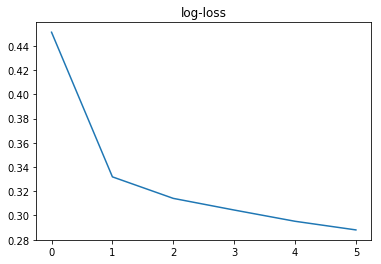

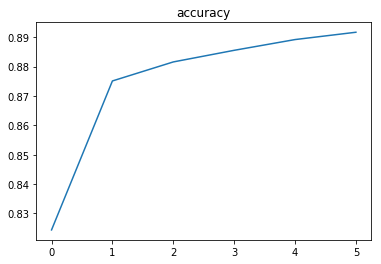

 60%|██████    | 6/10 [14:08<09:25, 141.41s/it]

KeyboardInterrupt: 

In [33]:
losses = []
accuracies = []
roc_aucs = []

for epoch in tqdm(range(10)):
    loss_float = 0
    accuracy_float = 0
    
    losses_epoch = []
    accuracies_epoch = []
    roc_aucs_epoch = []
    for X_cluster_graph in X_clusters_graph_train:
        predictions, (loss, accuracy) = run_train(X_cluster_graph=X_cluster_graph,
                                   X_predictions=X_predictions,
                                   optimizer=optimizer, sess=sess, 
                                   ndim_features_nodes=ndim_features_nodes, 
                                   ndim_features_edges=ndim_features_edges, 
                                   placeholders=placeholders,
                                   metrics=[loss_tf, accuracy_tf])
        losses_epoch.append(loss)
        accuracies_epoch.append(accuracy)
    clear_output()
    
    losses.append(np.mean(losses_epoch))
    plt.title('log-loss')
    plt.plot(losses)
    plt.show()

    accuracies.append(np.mean(accuracies_epoch))
    plt.title('accuracy')
    plt.plot(accuracies)
    plt.show()

### Eval

In [35]:
losses_test = []
accuracies_test = []
roc_aucs_test = []
predictions_total = [] 
y_total =[]

for X_cluster_graph in X_clusters_graph_eval:
    predictions = run_test(X_cluster_graph=X_cluster_graph, 
                                              X_predictions=X_predictions,
                                              sess=sess, 
                                              ndim_features_nodes=ndim_features_nodes, 
                                              ndim_features_edges=ndim_features_edges, 
                                              placeholders=placeholders)
    X_cluster_graph['predictions'] = predictions
    predictions_total.append(predictions)
    y_total.append(X_cluster_graph['Y_cluster_labels'])
    losses_test.append(loss)
    accuracies_test.append(accuracy)

In [36]:
predictions_total = np.concatenate(predictions_total)
y_total = np.concatenate(y_total)

In [37]:
from sklearn import metrics
accuracy = metrics.accuracy_score(np.argmax(y_total, axis=1), np.argmax(predictions_total, axis=1))
roc_auc = metrics.roc_auc_score(y_total, predictions_total)

In [38]:
accuracy

0.8944579705383994

In [39]:
roc_auc

0.976213418206342

## Test

In [43]:
test_file

'/mnt/vbelavin/test_3-4.csv'

In [40]:
X_test, Y_test, M_test, events_test = csv_to_numpy(file=test_file, num_classes=num_classes, test=True,
                                                   zero_class_exists=zero_class_exists, energy_cut=energy_cut)
shift = 0 if zero_class_exists else 1


 88%|████████▊ | 8832/9999 [00:16<00:02, 537.80it/s]


100%|██████████| 9999/9999 [00:18<00:00, 543.26it/s]

In [42]:
import tables
preds_array = []

for k, event in tqdm(list(enumerate(events_test))):
        X_cluster_graph, in_degree_max_local, out_degree_max_local = generate_graph_dataset(X=X_test[k], 
                                                                                            Y=Y_test[k], 
                                                                                            M=M_test[k],
                                                                                            n_neighbors=n_neighbors, 
                                                                                            in_degree_max=in_degree_max, 
                                                                                            out_degree_max=out_degree_max)
        
        predictions = run_test(X_cluster_graph=X_cluster_graph, 
                                               X_predictions=X_predictions,
                                               sess=sess, 
                                               ndim_features_nodes=ndim_features_nodes, 
                                               ndim_features_edges=ndim_features_edges, 
                                               placeholders=placeholders)
        preds_array.append(pd.DataFrame.from_dict(
            {
                'x': (X_test[k][:, 0] * X_MAX).astype(int), 
                'y': (X_test[k][:, 1] * Y_MAX).astype(int), 
                'z': (X_test[k][:, 2] * Z_MAX).astype(int),
                'event': event, 
                'pred': np.argmax(predictions, axis=1) + shift,
        }))



  3%|▎         | 341/9999 [00:33<15:38, 10.29it/s]


  7%|▋         | 684/9999 [01:03<14:20, 10.83it/s]


 10%|█         | 1030/9999 [01:33<13:38, 10.96it/s]


 14%|█▎        | 1361/9999 [02:06<13:22, 10.76it/s]


 17%|█▋        | 1718/9999 [02:36<12:34, 10.97it/s]


 20%|██        | 2036/9999 [03:07<12:13, 10.85it/s]


 24%|██▎       | 2351/9999 [03:40<11:58, 10.65it/s]


 27%|██▋       | 2694/9999 [04:11<11:22, 10.70it/s]


 30%|███       | 3042/9999 [04:42<10:44, 10.79it/s]


 34%|███▎      | 3352/9999 [05:15<10:24, 10.64it/s]


 37%|███▋      | 3673/9999 [05:44<09:53, 10.66it/s]


 40%|████      | 4001/9999 [06:18<09:26, 10.58it/s]


 43%|████▎     | 4338/9999 [06:51<08:56, 10.55it/s]


 47%|████▋     | 4672/9999 [07:25<08:28, 10.48it/s]


 50%|█████     | 5025/9999 [07:57<07:52, 10.52it/s]


 53%|█████▎    | 5349/9999 [08:32<07:25, 10.44it/s]


 57%|█████▋    | 5687/9999 [09:06<06:54, 10.41it/s]


 60%|██████    | 6009/9999 [09:37<06:23, 10.40it/s]


 63%|██████▎   | 6328/9999 [10:09<05:53, 10.38it/s]


 67%|██████▋   | 6672/9999 [10:42<05:20, 10.39it/s]


 70%|███████   | 7012/9999 [11:15<04:47, 10.38it/s]


 74%|███████▎  | 7353/9999 [11:45<04:13, 10.42it/s]


 77%|███████▋  | 7695/9999 [12:15<03:40, 10.47it/s]


 80%|████████  | 8026/9999 [12:47<03:08, 10.46it/s]


 84%|████████▎ | 8363/9999 [13:20<02:36, 10.45it/s]


 87%|████████▋ | 8696/9999 [13:53<02:04, 10.44it/s]


 90%|█████████ | 9042/9999 [14:24<01:31, 10.46it/s]


 94%|█████████▍| 9390/9999 [14:55<00:58, 10.48it/s]


 97%|█████████▋| 9716/9999 [15:30<00:27, 10.44it/s]


100%|██████████| 9999/9999 [15:53<00:00, 10.48it/s]


In [47]:
preds_df = pd.concat(preds_array)  

preds_df.to_csv(submission_file, index=False)
#preds_array.close()
#f_submission.close()

# Final tips & tricks

If you want to drive up your score try following things:

  * stack MOAR layer;
  * more epochs;
  * change Dense `state_updater` on LSTM/GRU `state_updater`(btw, you just need to uncomment a bit of code in the section `NNs` and in `tools.mpnn.build_network`);
  * data augmentation;
  * btw, you might have noticed that I use different `message_passers` but single `state_updater` for each step. This is called _weight tightening_ and used to deal with overfitting;
  
  You can apply the same technique to `message_passers` or, alternatively, unravel `state_updater`. It's all up to you!
  
  * do not discard domain knowledge. Even if it's not applicable to feature engeneering you still can use in graph construction / smart clustering / loss function choice / structure of MPNN.
  * this version of MPNN learns on one sample per iteration, using batches could impove quality;
  * play with learning rate / optimizer type;

In [48]:
process.memory_info().rss / 2**30

33.82579803466797